# Preparación del entorno y carga de datos

In [2]:
!sudo apt-get install unzip
!sudo apt-get install sox
!pip install opensmile

/bin/sh: sudo: command not found
/bin/sh: sudo: command not found
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [17]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import opensmile
import pandas as pd
import pickle
import time
import tqdm
from pathlib import Path
import sox 

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import (
    roc_curve,
    make_scorer,
    accuracy_score,
    fbeta_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

## Instancias a dataset a predecir

In [11]:
!unzip ./Propios/audios_propios.zip -d ./Propios/ravdess_propios

mkdir: cannot create directory ‘audios’: File exists
Archive:  ./Propios/audios_propios.zip
  inflating: ./Propios/ravdess_propios/03-01-01-01-01-01-05.wav  
  inflating: ./Propios/ravdess_propios/03-01-01-01-02-01-04.wav  
  inflating: ./Propios/ravdess_propios/03-01-01-01-02-01-05.wav  
  inflating: ./Propios/ravdess_propios/03-01-02-01-01-01-06.wav  
  inflating: ./Propios/ravdess_propios/03-01-02-01-02-01-06.wav  
  inflating: ./Propios/ravdess_propios/03-01-03-01-01-01-01.wav  
  inflating: ./Propios/ravdess_propios/03-01-03-01-01-01-02.wav  
  inflating: ./Propios/ravdess_propios/03-01-03-01-01-01-03.wav  
  inflating: ./Propios/ravdess_propios/03-01-03-01-01-01-04.wav  
  inflating: ./Propios/ravdess_propios/03-01-03-01-01-01-05.wav  
  inflating: ./Propios/ravdess_propios/03-01-03-01-01-01-06.wav  
  inflating: ./Propios/ravdess_propios/03-01-03-01-02-01-01.wav  
  inflating: ./Propios/ravdess_propios/03-01-03-01-02-01-02.wav  
  inflating: ./Propios/ravdess_propios/03-01-03-01

**Recorrer estructuras de archivos y extraer metadata**

In [13]:
ravdess = []
for file_path in glob.glob('./Propios/ravdess_propios/*.wav'):
    filename = Path(file_path).stem
    filename_parts = filename.split('-')
    metadata = {'file_path': file_path,
              'modality': filename_parts[0],
              'vocal_channel': filename_parts[1],
              'emotion': filename_parts[2],
              'emotional_intensity': filename_parts[3],
              'statement': filename_parts[4],
              'repetition': filename_parts[5],
              'actor': filename_parts[6]}
    ravdess.append(metadata)

df_ravdess_propios = pd.DataFrame(ravdess)

In [19]:
start = time.time()

feat_aux = []
for j in os.listdir("./Propios/ravdess_propios"):
    filename = "./Propios/ravdess_propios/" + j
    print("./Propios/ravdess_propios/" + j)

    ch = sox.file_info.channels(filename)
    print(f"channel: {ch}")
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
        num_channels=ch
    )

    feats = smile.process_file(filename)
    feats = feats.reset_index()
    feat_aux.append(feats)

end = time.time()
print(f"Tiempo: { round(end - start, 2) } segundos")

./Propios/ravdess_propios/03-01-08-01-02-01-05.wav
channel: 1
./Propios/ravdess_propios/03-01-08-01-01-01-01.wav
channel: 2
./Propios/ravdess_propios/03-01-05-02-02-01-03.wav
channel: 2
./Propios/ravdess_propios/03-01-05-02-01-01-01.wav
channel: 2
./Propios/ravdess_propios/03-01-08-01-01-01-05.wav
channel: 1
./Propios/ravdess_propios/03-01-03-01-01-01-06.wav
channel: 1
./Propios/ravdess_propios/03-01-08-01-02-01-06.wav
channel: 1
./Propios/ravdess_propios/03-01-08-01-01-01-06.wav
channel: 1
./Propios/ravdess_propios/03-01-08-01-01-01-03.wav
channel: 2
./Propios/ravdess_propios/03-01-03-01-01-01-02.wav
channel: 2
./Propios/ravdess_propios/03-01-07-01-01-01-04.wav
channel: 1
./Propios/ravdess_propios/03-01-04-01-01-01-02.wav
channel: 2
./Propios/ravdess_propios/03-01-03-01-02-01-02.wav
channel: 2
./Propios/ravdess_propios/03-01-03-01-02-01-06.wav
channel: 1
./Propios/ravdess_propios/03-01-05-02-01-01-02.wav
channel: 2
./Propios/ravdess_propios/03-01-08-01-02-01-01.wav
channel: 2
./Propio

In [20]:
df_ravdess_propios.shape

(42, 8)

**Calculamos los atributos de alto nivel (Functionals)**

In [21]:
df_feats = pd.concat(feat_aux)
df_feats = df_feats.rename(columns={'file': 'file_path'})

In [22]:
df_feats.head()

,file_path,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean-1,slopeUV500-1500_sma3nz_amean-1,spectralFluxUV_sma3nz_amean-1,loudnessPeaksPerSec-1,VoicedSegmentsPerSec-1,MeanVoicedSegmentLengthSec-1,StddevVoicedSegmentLengthSec-1,MeanUnvoicedSegmentLength-1,StddevUnvoicedSegmentLength-1,equivalentSoundLevel_dBp-1
0,./Propios/ravdess_propios/03-01-08-01-02-01-05...,0 days,0 days 00:00:05.472000,38.585224,0.101418,35.463207,38.217197,40.764786,5.301579,31.868803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,./Propios/ravdess_propios/03-01-08-01-01-01-01...,0 days,0 days 00:00:04.689342404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.012248,-0.000712,0.399740,2.355460,3.260870,0.172667,0.325443,0.112667,0.116703,-18.135742
0,./Propios/ravdess_propios/03-01-05-02-02-01-03...,0 days,0 days 00:00:04.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013234,-0.010790,0.445838,3.189066,2.309469,0.347000,0.338587,0.091429,0.104667,-16.105972
0,./Propios/ravdess_propios/03-01-05-02-01-01-01...,0 days,0 days 00:00:04.582766440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.022259,-0.000362,0.230240,2.407002,2.433628,0.224545,0.298888,0.151667,0.195185,-20.174620
0,./Propios/ravdess_propios/03-01-08-01-01-01-05...,0 days,0 days 00:00:06.120000,36.163647,0.161040,33.768730,38.291878,40.268578,6.499847,232.620514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_propios = pd.merge(df_ravdess_propios,df_feats, on="file_path", how="left")

In [39]:
num_columns = [col for col in df_propios.columns if df_propios[col].dtype != "object"]
num_columns

['start',
 'end',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3_std

In [40]:
df_propios.shape

(42, 274)

In [43]:
drop_columns = [
    "file_path",
    "start",
    "end",
#     "Unnamed: 0",
#     'Unnamed: 0.1',
    "modality",# 03 = audio-only
    "vocal_channel", # (01 = speech, 02 = song).
#     "emotion",
    "emotional_intensity", #(01 = normal, 02 = strong)
    "statement", #(01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    "repetition", #(01 = 1st repetition, 02 = 2nd repetition).
    "actor", #(01 to 24. Odd numbered actors are male, even numbered actors are female).
]

In [44]:
df_propios = df_propios.drop(drop_columns, axis = 1)
# df_propios.to_csv('05.01.df_propios.csv')

In [131]:
df_propios = pd.read_csv("05.01.df_propios.csv")

<BarContainer object of 7 artists>

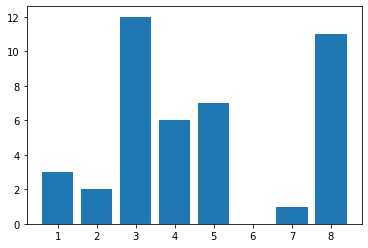

In [145]:
plt.bar(
    df_propios.groupby(["emotion"]).loudness_sma3_amean.count().index,
    df_propios.groupby(["emotion"]).loudness_sma3_amean.count(),
)

In [132]:
x_propios = df_propios.loc[:, df_propios.columns != "emotion"]

In [133]:
y_propios = np.int64(df_propios["emotion"])

In [134]:
drop_columns = [
    "file_path",
    "start",
    "end",
    "Unnamed: 0",
    'Unnamed: 0.1',
    "modality",# 03 = audio-only
    "vocal_channel", # (01 = speech, 02 = song).
#     "emotion",
    "emotional_intensity", #(01 = normal, 02 = strong)
    "statement", #(01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    "repetition", #(01 = 1st repetition, 02 = 2nd repetition).
    "actor", #(01 to 24. Odd numbered actors are male, even numbered actors are female).
]

In [150]:
df_propios = df_propios.drop(["Unnamed: 0"], axis = 1)

## Dataset original

In [167]:
df_original = pd.read_csv("01.df.procesado.csv")

In [168]:
df_original

,Unnamed: 0,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,start,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0,./audios/ravdess/Actor_23/03-01-07-02-02-01-23...,3,1,7,2,2,1,23,0 days 00:00:00,...,0.075190,0.014015,0.022255,2.150538,1.089918,0.282500,0.126763,0.490000,0.397291,-36.658245
1,1,./audios/ravdess/Actor_23/03-02-03-02-02-01-23...,3,2,3,2,2,1,23,0 days 00:00:00,...,0.020998,0.009869,0.018871,1.492537,0.646552,0.820000,0.277248,0.527500,0.438770,-29.391884
2,2,./audios/ravdess/Actor_23/03-01-04-01-02-01-23...,3,1,4,1,2,1,23,0 days 00:00:00,...,0.047365,0.011048,0.011381,2.247191,0.569801,0.590000,0.160000,0.760000,0.296985,-43.332924
3,3,./audios/ravdess/Actor_23/03-02-04-02-02-01-23...,3,2,4,2,2,1,23,0 days 00:00:00,...,0.041743,0.012340,0.007390,1.394422,0.603622,0.930000,0.885701,0.527500,0.420260,-37.549572
4,4,./audios/ravdess/Actor_23/03-01-02-02-02-02-23...,3,1,2,2,2,2,23,0 days 00:00:00,...,0.053580,0.011590,0.005245,1.535088,0.886918,0.387500,0.206079,0.574000,0.424999,-43.261425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,2447,./audios/ravdess/Actor_22/03-02-02-02-02-01-22...,3,2,2,2,2,1,22,0 days 00:00:00,...,0.098631,0.014208,0.011939,1.257862,0.633914,1.045000,1.346189,0.408000,0.423386,-33.219906
2448,2448,./audios/ravdess/Actor_22/03-02-01-01-02-02-22...,3,2,1,1,2,2,22,0 days 00:00:00,...,0.063631,0.011066,0.007059,1.890756,0.636943,0.863333,0.839259,0.512500,0.468955,-33.061134
2449,2449,./audios/ravdess/Actor_22/03-01-06-02-02-02-22...,3,1,6,2,2,2,22,0 days 00:00:00,...,0.061096,0.006023,0.019152,2.228412,0.847458,0.490000,0.074833,0.663333,0.407458,-29.857113
2450,2450,./audios/ravdess/Actor_22/03-02-02-02-02-02-22...,3,2,2,2,2,2,22,0 days 00:00:00,...,0.076382,0.012524,0.007605,2.079395,0.763359,0.762500,0.600432,0.522500,0.453673,-35.297977


In [169]:
drop_columns = [
    "file_path",
    "start",
    "end",
    "Unnamed: 0",
#     'Unnamed: 0.1',
    "modality",# 03 = audio-only
    "vocal_channel", # (01 = speech, 02 = song).
#     "emotion",
    "emotional_intensity", #(01 = normal, 02 = strong)
    "statement", #(01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    "repetition", #(01 = 1st repetition, 02 = 2nd repetition).
#     "actor", #(01 to 24. Odd numbered actors are male, even numbered actors are female).
]

In [170]:
df_original = df_original.drop(drop_columns, axis = 1)

<BarContainer object of 8 artists>

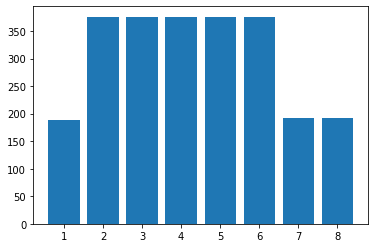

In [171]:
plt.bar(
    df_original.groupby(["emotion"]).loudness_sma3_amean.count().index,
    df_original.groupby(["emotion"]).loudness_sma3_amean.count(),
)

# Entrenando el mejor modelo (RF)

Al comparar las performance del bagging , el AdaBoost y el Random Forest se obtuvo un mejor desempeño por parte del RF con los siguientes hiperparámetros:

In [172]:
rf = RandomForestClassifier(n_estimators=3050, bootstrap=True, random_state=42)

In [173]:
df_propios.shape

(42, 89)

In [174]:
X_train, x_test, y_train, y_test = train_test_split(
    df_original.loc[:, df_original.columns != "emotion"],
    df_original["emotion"],
    stratify=df_original["emotion"],
    random_state=66,
)

In [175]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=3050, random_state=42)

# Resultados

In [176]:
y_pred_propios = rf.predict(x_propios)

In [181]:
# labels_cm = ['Neu.', 'Calm','Hap.','Sad','Angry','Fear.','Disg.','Surpr.']
labels_cm = ['Neu.', 'Calm','Hap.','Sad','Angry','Fear.','Disg.','Surpr.']


In [178]:
unique, counts = np.unique(y_propios, return_counts=True)
dict(zip(unique, counts))

{1: 3, 2: 2, 3: 12, 4: 6, 5: 7, 7: 1, 8: 11}

In [179]:
unique, counts = np.unique(y_pred_propios, return_counts=True)
dict(zip(unique, counts))

{3: 4, 4: 2, 5: 24, 6: 10, 7: 2}

[Text(0, 0.5, 'Neu.'),
 Text(0, 1.5, 'Calm'),
 Text(0, 2.5, 'Hap.'),
 Text(0, 3.5, 'Sad'),
 Text(0, 4.5, 'Angry'),
 Text(0, 5.5, 'Fear.'),
 Text(0, 6.5, 'Disg.'),
 Text(0, 7.5, 'Surpr.')]

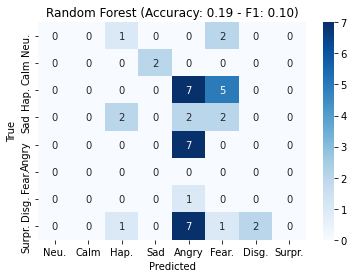

In [182]:
ax = plt.subplot()
cm = confusion_matrix(y_propios, y_pred_propios)
sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
ax.set_title("Random Forest (Accuracy: 0.19 - F1: 0.10)")
ax.xaxis.set_ticklabels(labels_cm)
ax.yaxis.set_ticklabels(labels_cm)

In [183]:
print(classification_report(y_propios, y_pred_propios))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         6
           5       0.29      1.00      0.45         7
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00        11

    accuracy                           0.17        42
   macro avg       0.04      0.12      0.06        42
weighted avg       0.05      0.17      0.08        42



/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/User/.local/lib/python3.6/site-packages/sklearn/

## Probando con Adaboost

In [184]:
best_adaboost = AdaBoostClassifier(
    DecisionTreeClassifier(class_weight="balanced"),
    n_estimators=1640,
    learning_rate=0.707,
)
best_adaboost.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'),
                   learning_rate=0.707, n_estimators=1640)

In [185]:
y_pred_propios_ada = best_adaboost.predict(x_propios)

In [186]:
print(classification_report(y_propios, y_pred_propios_ada))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         6
           5       0.25      0.71      0.37         7
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00        11

    accuracy                           0.12        42
   macro avg       0.03      0.09      0.05        42
weighted avg       0.04      0.12      0.06        42



/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/User/.local/lib/python3.6/site-packages/sklearn/

[Text(0, 0.5, 'Neu.'),
 Text(0, 1.5, 'Calm'),
 Text(0, 2.5, 'Hap.'),
 Text(0, 3.5, 'Sad'),
 Text(0, 4.5, 'Angry'),
 Text(0, 5.5, 'Fear.'),
 Text(0, 6.5, 'Disg.'),
 Text(0, 7.5, 'Surpr.')]

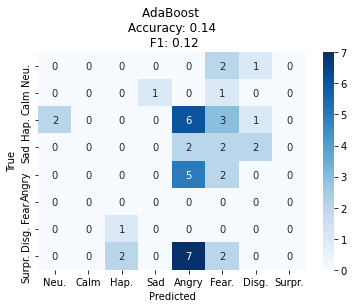

In [187]:
ax = plt.subplot()
cm = confusion_matrix(y_propios, y_pred_propios_ada)
sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
ax.set_title("AdaBoost \n Accuracy: 0.14 \n F1: 0.12")
ax.xaxis.set_ticklabels(labels_cm)
ax.yaxis.set_ticklabels(labels_cm)

In [188]:
best_adaboost

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'),
                   learning_rate=0.707, n_estimators=1640)